In [1]:
import time
t_start = time.time()

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # suppress tensorflow information messages

import sys
import numpy as np
from scipy import stats
import scipy as sp
import multiprocessing
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

HOME_PATH = os.path.abspath("/root/work/QE-mls") # path to QE_mls
sys.path.append(HOME_PATH + "/qe")
print("Home path:", HOME_PATH)

# custom modules
import paper_plot as pp
# Import the W boson regressor module
import nn
nn.BATCH_SIZE = 1024


Home path: /root/work/QE-mls


In [2]:
# ROOT need to be imported after tensorflow
import ROOT
from ROOT import TLorentzVector, TVector3

# some global variables
dir_name = HOME_PATH + "/14th_trial/reg_main/ww_resregressor_result/"
plot = pp.Plotter()
WORKERS = 20

In [3]:
import h5py


def load_particles_from_h5(filename="mc20_truth.h5"):
    """
    Load particle data from an HDF5 file

    Args:
        filename: Path to the HDF5 file

    Returns:
        Dictionary with the loaded data
    """
    result = {}

    with h5py.File(filename, "r") as f:
        # For each group in the file
        for group_name in f.keys():
            group_data = {}

            # Load datasets (numpy arrays)
            for dataset_name in f[group_name].keys():
                group_data[dataset_name] = f[group_name][dataset_name][:]

            # Load attributes (scalars)
            for attr_name, attr_value in f[group_name].attrs.items():
                group_data[attr_name] = attr_value

            result[group_name] = group_data

    return result

In [4]:
mc20_data = load_particles_from_h5("/root/data/mc20_truth.h5")
mc20_data.keys()

dict_keys(['higgs', 'lead_w', 'sublead_w', 'truth_dilep', 'truth_dilep_car', 'truth_lead_lep', 'truth_lead_lep_car', 'truth_lead_nu', 'truth_lead_nu_car', 'truth_sublead_lep', 'truth_sublead_lep_car', 'truth_sublead_nu', 'truth_sublead_nu_car'])

In [5]:
# SM truth
truth_lead_lep = mc20_data["truth_lead_lep"]
truth_sublead_lep = mc20_data["truth_sublead_lep"]
truth_lead_nu = mc20_data["truth_lead_nu"]
truth_sublead_nu = mc20_data["truth_sublead_nu"]
truth_lead_lep_p4 = mc20_data["truth_lead_lep"]["p4"]
truth_sublead_lep_p4 = mc20_data["truth_sublead_lep"]["p4"]
truth_lead_nu_p4 = mc20_data["truth_lead_nu"]["p4"]
truth_sublead_nu_p4 = mc20_data["truth_sublead_nu"]["p4"]
truth_met_pt = np.sqrt(np.square((truth_lead_nu_p4 + truth_sublead_nu_p4)[...,0:2]).sum(axis=-1))

# CAR truth
truth_lead_lep_car = mc20_data["truth_lead_lep_car"]
truth_sublead_lep_car = mc20_data["truth_sublead_lep_car"]
truth_lead_nu_car = mc20_data["truth_lead_nu_car"]
truth_sublead_nu_car = mc20_data["truth_sublead_nu_car"]
truth_lead_lep_car_p4 = mc20_data["truth_lead_lep_car"]["p4"]
truth_sublead_lep_car_p4 = mc20_data["truth_sublead_lep_car"]["p4"]
truth_lead_nu_car_p4 = mc20_data["truth_lead_nu_car"]["p4"]
truth_sublead_nu_car_p4 = mc20_data["truth_sublead_nu_car"]["p4"]
truth_met_pt_car = np.sqrt(np.square((truth_lead_nu_car_p4 + truth_sublead_nu_car_p4)[...,0:2]).sum(axis=-1))

# W bosons (SM and CAR use the same W bosons data)
w_lead_p4 = mc20_data["lead_w"]["p4"]
w_sublead_p4 = mc20_data["sublead_w"]["p4"]

In [6]:
print("Truth: pre-cut")
cut_pre_pt_lead = truth_lead_lep["pt"] > 22
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = truth_sublead_lep["pt"] > 15
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.square(truth_lead_lep["energy"] + truth_sublead_lep["energy"])
    - np.square(truth_lead_lep["px"] + truth_sublead_lep["px"])
    - np.square(truth_lead_lep["py"] + truth_sublead_lep["py"])
    - np.square(truth_lead_lep["pz"] + truth_sublead_lep["pz"])
    > 10**2
)
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = truth_met_pt > 20
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print("Total", len(truth_lead_lep["energy"]) - np.sum(PRE_CUT * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

# CAR
print("")
print("CAR: pre-cut")
cut_pre_pt_lead = truth_lead_lep_car["pt"] > 22
print(len(truth_lead_lep_car["energy"]) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = truth_sublead_lep_car["pt"] > 15
print(len(truth_lead_lep_car["energy"]) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.square(truth_lead_lep_car["energy"] + truth_sublead_lep_car["energy"])
    - np.square(truth_lead_lep_car["px"] + truth_sublead_lep_car["px"])
    - np.square(truth_lead_lep_car["py"] + truth_sublead_lep_car["py"])
    - np.square(truth_lead_lep_car["pz"] + truth_sublead_lep_car["pz"])
    > 10**2
)
print(len(truth_lead_lep_car["energy"]) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = truth_met_pt_car > 20
print(len(truth_lead_lep_car["energy"]) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT_CAR = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print("Total", len(truth_lead_lep_car["energy"]) - np.sum(PRE_CUT_CAR * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

Truth: pre-cut
260653
1174171
148392
287355
Total 1502903

CAR: pre-cut
336735
1292162
65248
441435
Total 1634918


In [7]:
# force to use the same cuts for both truth and CAR

PRE_CUT_INST = PRE_CUT_CAR & PRE_CUT
print("Total", np.sum(PRE_CUT_INST * 1))

Total 700374


In [8]:
# training objects
lead_lep_px = truth_lead_lep["px"][PRE_CUT_INST]
lead_lep_py = truth_lead_lep["py"][PRE_CUT_INST]
lead_lep_pz = truth_lead_lep["pz"][PRE_CUT_INST]
lead_lep_energy = truth_lead_lep["energy"][PRE_CUT_INST]
sublead_lep_px = truth_sublead_lep["px"][PRE_CUT_INST]
sublead_lep_py = truth_sublead_lep["py"][PRE_CUT_INST]
sublead_lep_pz = truth_sublead_lep["pz"][PRE_CUT_INST]
sublead_lep_energy = truth_sublead_lep["energy"][PRE_CUT_INST]
lead_nu_px = truth_lead_nu_car["px"][PRE_CUT_INST]
lead_nu_py = truth_lead_nu_car["py"][PRE_CUT_INST]
sublead_nu_px = truth_sublead_nu_car["px"][PRE_CUT_INST]
sublead_nu_py = truth_sublead_nu_car["py"][PRE_CUT_INST]
met_px = lead_nu_px + sublead_nu_px
met_py = lead_nu_py + sublead_nu_py

np.random.seed(nn.SEED)
shuffle_ind = np.random.permutation(len(lead_lep_px))

train = np.column_stack(
    (
        lead_lep_px,
        lead_lep_py,
        lead_lep_pz,
        lead_lep_energy,
        sublead_lep_px,
        sublead_lep_py,
        sublead_lep_pz,
        sublead_lep_energy,
        met_px,
        met_py,
    )
)

# train = train[shuffle_ind]
print("Training objects shape:", train.shape)

Training objects shape: (700374, 10)


In [9]:
# Ensure ROOT is properly initialized
ROOT.gROOT.SetBatch(True)

def w_rest_booster(particles):

    WpBoson = TLorentzVector(*particles[:4]) # (px, py, pz, energy)
    WpLepton = TLorentzVector(*particles[4:8])
    WnBoson = TLorentzVector(*particles[8:12])
    WnLepton = TLorentzVector(*particles[12:16])
    
    # construct Higgs 4-vector
    Higgs = WpBoson + WnBoson

    # construct a moving orthogonal basis (k,r,n)
    Beam_p = TLorentzVector(0, 0, 1, 1)  # spatial-axis

    # define boost vector
    Higgsb = Higgs.BoostVector()

    # (1) performs a boost transformation from the rod frame to the rawal one.
    # Perform boost transformation from the rod frame to the rawal one
    for vec in [WpBoson, WpLepton, WnBoson, WnLepton, Beam_p]:
        vec.Boost(-Higgsb)

    # 2. Define (k,r,n) -> definitions are in Alan's paper
    k_per = TVector3(WpBoson.X(), WpBoson.Y(), WpBoson.Z())
    p_per = TVector3(Beam_p.X(), Beam_p.Y(), Beam_p.Z())  # in the Higgs rest frame
    k = k_per.Unit()  # normalized -> unit vector
    p = p_per.Unit()
    y = p.Dot(k)
    r_length = np.sqrt(1 - y * y)
    r = (1 / r_length) * (p - y * k)
    n = (1 / r_length) * (p.Cross(k))  # (1/sin)*sin = 1 -> unit vector

    # 3. Further boost to W+ and W- frame respectively
    WpkBoost = WpBoson.BoostVector()
    WpBoson.Boost(-WpkBoost)
    WpLepton.Boost(-WpkBoost)
    WnkBoost = WnBoson.BoostVector()
    WnBoson.Boost(-WnkBoost)
    WnLepton.Boost(-WnkBoost)

    # 4. Map all particle to (k,r,n) frame
    WpLp = WpLepton.Vect()  # momentum in (k,r,n)
    WnLp = WnLepton.Vect()
    # Mapping to n-r-k basis
    WpLp_k = TLorentzVector(WpLp.Dot(n), WpLp.Dot(r), WpLp.Dot(k), WpLepton.E())
    WnLp_k = TLorentzVector(WnLp.Dot(n), WnLp.Dot(r), WnLp.Dot(k), WnLepton.E())

    # Also fix the W rest frame arrays to extract components properly
    w_rest_WpLepton = np.array([WpLp_k.X(), WpLp_k.Y(), WpLp_k.Z(), WpLp_k.T()])
    w_rest_WnLepton = np.array([WnLp_k.X(), WnLp_k.Y(), WnLp_k.Z(), WnLp_k.T()])

    return (
        w_rest_WpLepton,
        w_rest_WnLepton,
    )


def result_generator(particles):
    with multiprocessing.Pool(WORKERS) as pool:
        # Retrieve the output from the pool
        results = list(pool.map(w_rest_booster, particles))

    # Unpack the results
    w_rest_lp, w_rest_ln = zip(*results)
    w_rest_lp = np.vstack(w_rest_lp)
    w_rest_ln = np.vstack(w_rest_ln)
    return (w_rest_lp, w_rest_ln,)

In [10]:
w_lead_p4 = mc20_data["lead_w"]["p4"][PRE_CUT_INST]
w_sublead_p4 = mc20_data["sublead_w"]["p4"][PRE_CUT_INST]
lead_lep_p4 = mc20_data["truth_lead_lep"]["p4"][PRE_CUT_INST]
sublead_lep_p4 = mc20_data["truth_sublead_lep"]["p4"][PRE_CUT_INST]

particles = np.concatenate(
    [
        w_lead_p4,
        lead_lep_p4,
        w_sublead_p4,
        sublead_lep_p4,
    ],
    axis=1,
)

w_rest_lep_lead_p4, w_rest_lep_sublead_p4 = result_generator(particles)

In [11]:
def theta(p4):
    p3_mag = np.sqrt(np.sum(np.square(p4[:, 0:3]), axis=1))  # Calculate the magnitude of the spatial components
    pz = p4[:, 2]  # Extract the pz component
    return np.arccos(np.divide(pz, p3_mag)) / np.pi  # Normalize to [0, 1]

def phi(p4):
    phi = np.arctan2(p4[:, 1], p4[:, 0])  # Calculate the azimuthal angle
    return phi / np.pi  # normalize to [-1, 1]

lead_theta = theta(w_rest_lep_lead_p4)
lead_phi = phi(w_rest_lep_lead_p4)
sublead_theta = theta(w_rest_lep_sublead_p4)
sublead_phi = phi(w_rest_lep_sublead_p4)

target = np.concatenate(
	[
		np.column_stack([lead_theta, lead_phi]),
		np.column_stack([sublead_theta, sublead_phi]),
	],
	axis=1,
)
print("Target objects shape:", target.shape)

Target objects shape: (700374, 4)


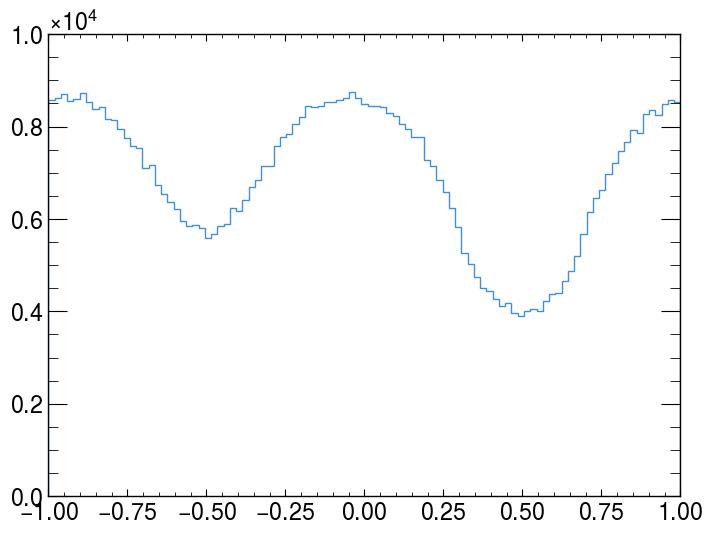

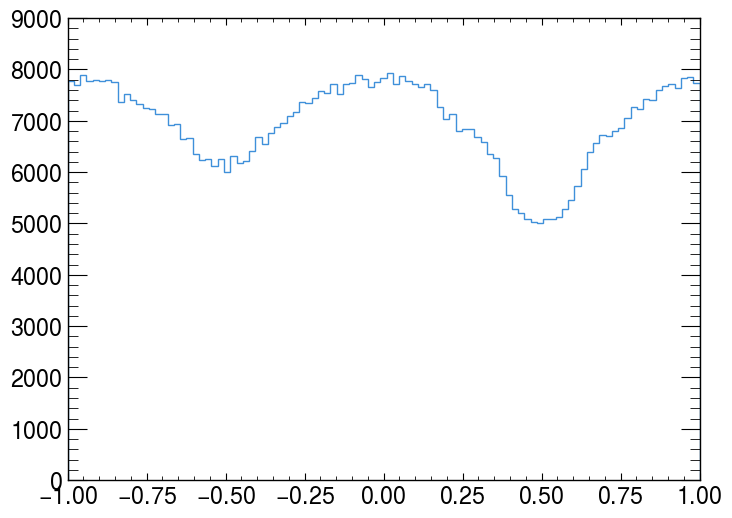

In [12]:
plt.hist(lead_phi, bins=101, range=(-1, 1), histtype="step", label="Sublead lepton phi")
plt.show()
plt.hist(sublead_phi, bins=101, range=(-1, 1), histtype="step", label="Sublead lepton phi")
plt.show()

In [13]:
# Train-test split
if len(train) == len(target):
	indices = np.arange(len(train))
else:
	sys.exit("Error: train and targe shapes do not match!")

train_idx, temp_idx = train_test_split(
	indices, train_size=0.8, random_state=nn.SEED
)
valid_idx, test_idx = train_test_split(
	temp_idx, train_size=0.5, random_state=nn.SEED
)

train_x, valid_x, test_x = train[train_idx], train[valid_idx], train[test_idx]
train_y, valid_y, test_y = target[train_idx], target[valid_idx], target[test_idx]

print("Train training shape:", train_x.shape, "Valid training shape:", valid_x.shape, "Test training shape:", test_x.shape)
print("Train target shape:", train_y.shape, "Valid target shape:", valid_y.shape, "Test target shape:", test_y.shape)

Train training shape: (560299, 10) Valid training shape: (70037, 10) Test training shape: (70038, 10)
Train target shape: (560299, 4) Valid target shape: (70037, 4) Test target shape: (70038, 4)


In [14]:
# W&B initialization
wandb.init(
    project='PcRes regressor w-rest training', 
    name='MMD MMD batch_size: %d' % nn.BATCH_SIZE)
config = wandb.config
config.batch_size = nn.BATCH_SIZE

# Create datasets
train_dataset = (
	tf.data.Dataset.from_tensor_slices((train_x, train_y))
	.cache()
	.batch(nn.BATCH_SIZE)
	.prefetch(tf.data.AUTOTUNE)
)
valid_dataset = (
	tf.data.Dataset.from_tensor_slices((valid_x, valid_y))
	.cache()
	.batch(nn.BATCH_SIZE)
	.prefetch(tf.data.AUTOTUNE)
)

# Build and train model
base_model = nn.build_model(input_shape=train_x.shape[-1])
model = nn.CustomModel(base_model)
model.summary()
model.compile(
	optimizer=tf.keras.optimizers.Adam(learning_rate=nn.LEARNING_RATE),
	loss_weights=nn.LOSS_WEIGHTS,
)

callbacks = [
	tf.keras.callbacks.EarlyStopping(
		monitor="val_loss", patience=10, restore_best_weights=True
	),
	nn.EpochUpdater(),
	nn.LambdaTracker(),
	WandbMetricsLogger(), 
    # WandbModelCheckpoint(
    #     "best_val_loss.weights.h5",
    #     monitor="val_loss",
    # ),
]

history = model.fit(
	train_dataset,
	validation_data=valid_dataset,
	epochs=nn.EPOCHS,
	callbacks=callbacks,
	verbose=0,
)

wandb: Currently logged in as: yygarypeng (nthu-expt-hep) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Model: "custom_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 4)              │       424,972 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 424,972 (1.62 MB)

 Trainable params: 418,620 (1.60 MB)

 Non-trainable params: 6,352 (24.81 KB)

Epoch 0; loss: 3.320E+00; mae_loss: 5.049E-01; neg_r2_loss: 5.701E-01; phi_mmd0_loss: 3.990E-01; phi_mmd1_loss: 3.011E-01; theta_mmd0_loss: 7.276E-01; theta_mmd1_loss: 8.821E-01; val_loss: 1.484E+00; val_mae_loss: 4.605E-01; val_neg_r2_loss: 4.560E-01; val_phi_mmd0_loss: 1.043E-01; val_phi_mmd1_loss: 1.084E-01; val_theta_mmd0_loss: 6.016E-02; val_theta_mmd1_loss: 2.906E-01
Epoch 1; loss: 1.310E+00; mae_loss: 4.759E-01; neg_r2_loss: 6.108E-01; phi_mmd0_loss: 2.801E-02; phi_mmd1_loss: 8.859E-02; theta_mmd0_loss: 5.879E-02; theta_mmd1_loss: 1.832E-01; val_loss: 9.986E-01; val_mae_loss: 4.037E-01; val_neg_r2_loss: 2.191E-01; val_phi_mmd0_loss: 2.932E-02; val_phi_mmd1_loss: 9.696E-02; val_theta_mmd0_loss: 3.160E-02; val_theta_mmd1_loss: 3.322E-02
Epoch 2; loss: 1.002E+00; mae_loss: 4.399E-01; neg_r2_loss: 4.574E-01; phi_mmd0_loss: 1.426E-02; phi_mmd1_loss: 4.531E-02; theta_mmd0_loss: 2.612E-02; theta_mmd1_loss: 3.601E-02; val_loss: 8.865E-01; val_mae_loss: 3.825E-01; val_neg_r2_loss: 1.203E

I0000 00:00:1752550044.591193 1110106 service.cc:145] XLA service 0x7bfde0016df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752550044.591214 1110106 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
I0000 00:00:1752550052.506511 1110271 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_31', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1752550052.601380 1110265 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_31', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1752550052.625390 1110283 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_31', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1752550052.872386 1110259 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function

In [15]:
pred_y = model.predict(test_x)

2189/2189 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


I0000 00:00:1752550607.163925 1137360 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1752550610.404383 1137478 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 8 bytes spill stores, 8 bytes spill loads



In [16]:
label_lead_w_theta = test_y[:, 0]
label_lead_w_phi = test_y[:, 1]
label_sublead_w_theta = test_y[:, 2]
label_sublead_w_phi = test_y[:, 3]

pred_lead_w_theta = pred_y[:, 0]
pred_lead_w_phi = pred_y[:, 1]
pred_sublead_w_theta = pred_y[:, 2]
pred_sublead_w_phi = pred_y[:, 3]

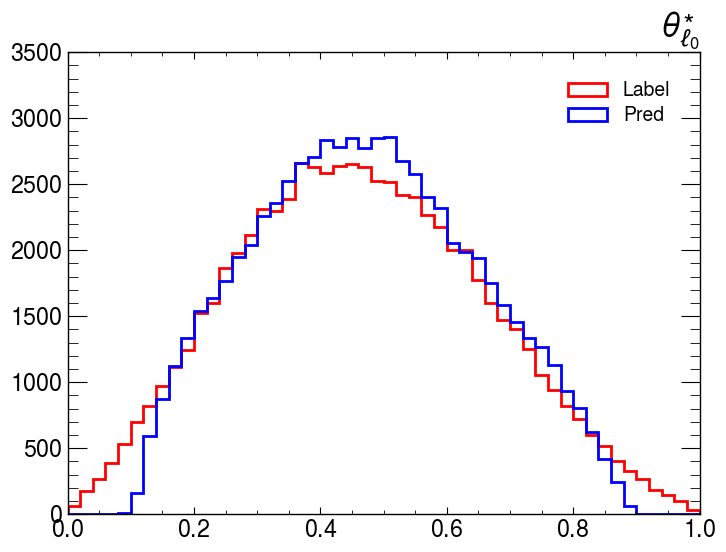

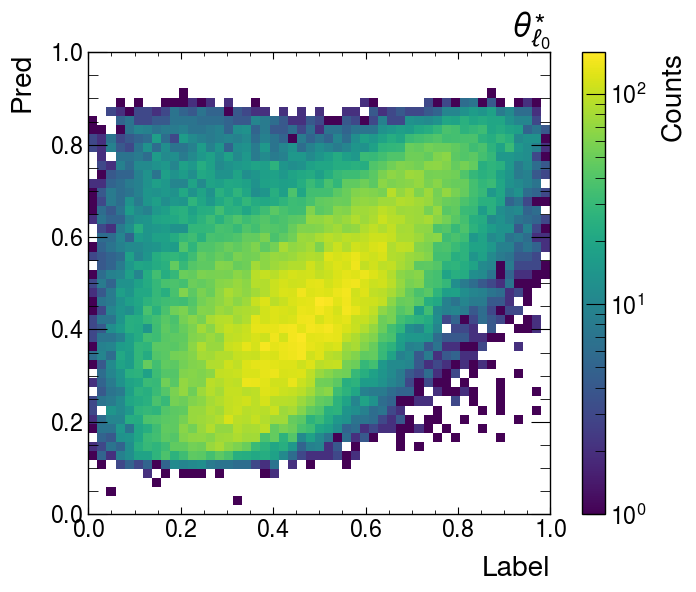

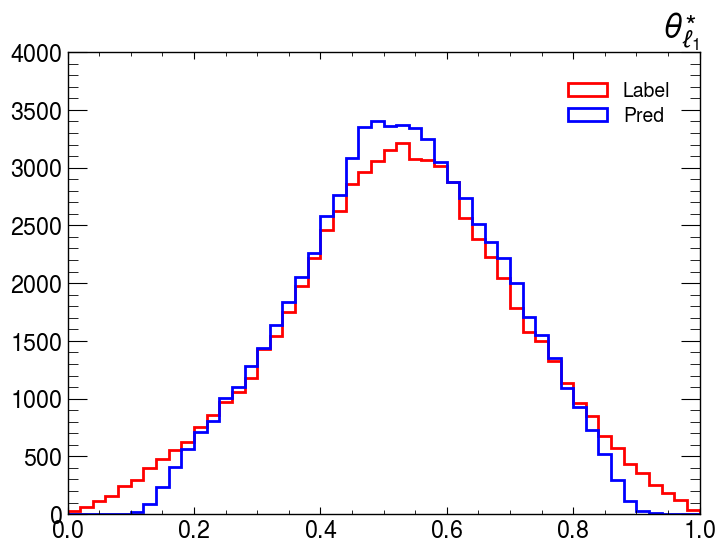

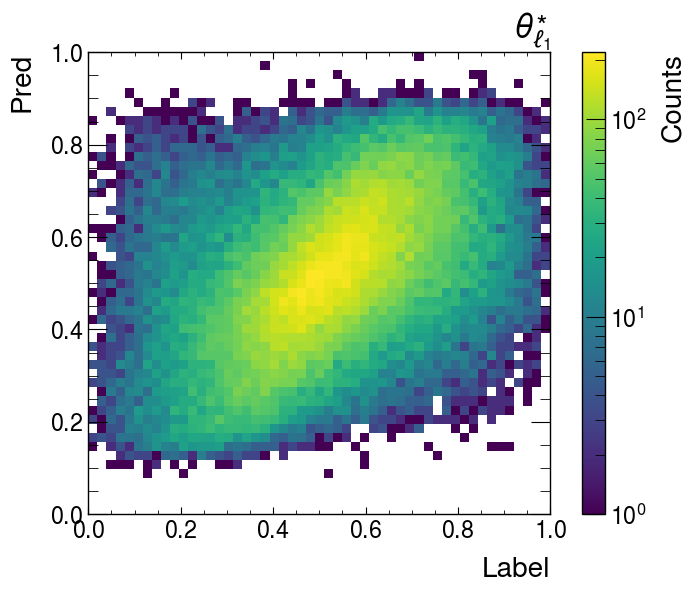

In [17]:
# theta

# lead
plt.hist(label_lead_w_theta, bins=np.linspace(0, 1, 51), label=r"Label", histtype="step", linewidth=2, color="red")
plt.hist(pred_lead_w_theta, bins=np.linspace(0, 1, 51), label=r"Pred", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.title(r"$\theta^{\ast}_{\ell_0}$", loc='right')
plt.show()

plt.hist2d(
	label_lead_w_theta,
	pred_lead_w_theta,
	bins=(51, 51),
	range=([0, 1], [0, 1]),
	cmap="viridis",
	cmin=1,
	norm=LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel(r"Pred")
plt.xlabel(r"Label")
plt.title(r"$\theta^{\ast}_{\ell_0}$", loc='right')
plt.show()

# sublead
plt.hist(label_sublead_w_theta, bins=np.linspace(0, 1, 51), label=r"Label", histtype="step", linewidth=2, color="red")
plt.hist(pred_sublead_w_theta, bins=np.linspace(0, 1, 51), label=r"Pred", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.title(r"$\theta^{\ast}_{\ell_1}$", loc='right')
plt.show()

plt.hist2d(
	label_sublead_w_theta,
	pred_sublead_w_theta,
	bins=(51, 51),
	range=([0, 1], [0, 1]),
	cmap="viridis",
	cmin=1,
	norm=LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel(r"Pred")
plt.xlabel(r"Label")
plt.title(r"$\theta^{\ast}_{\ell_1}$", loc='right')
plt.show()


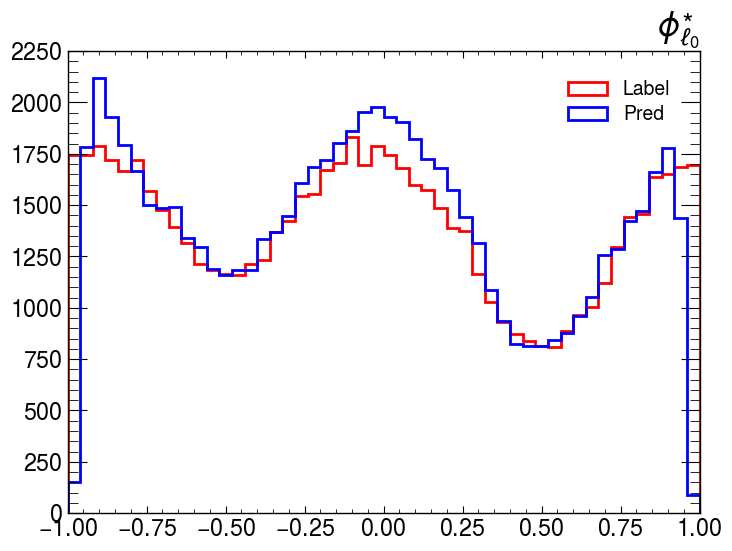

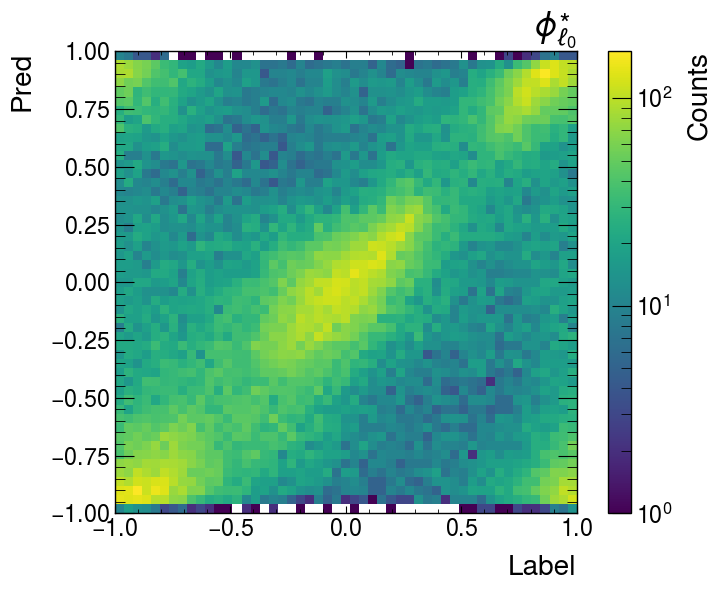

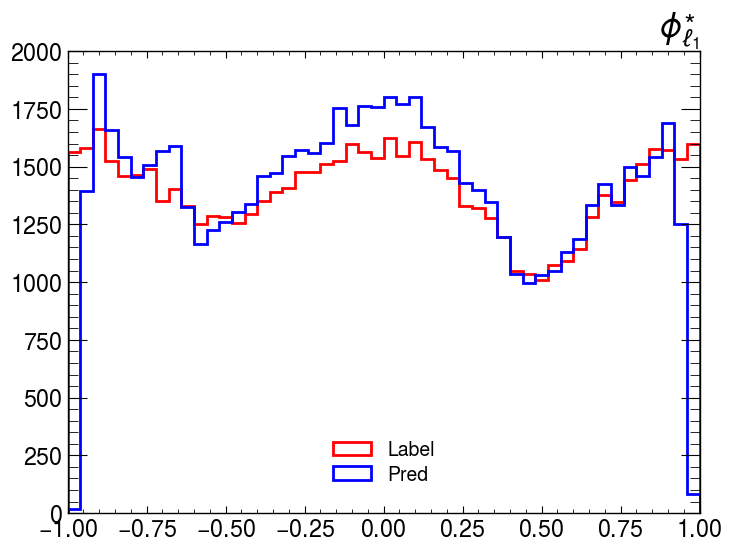

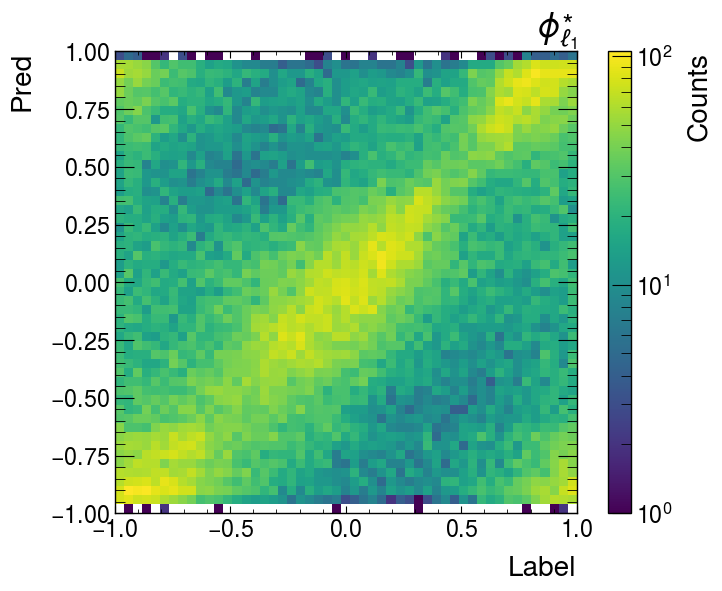

In [18]:
# phi

# lead
plt.hist(label_lead_w_phi, bins=np.linspace(-1, 1, 51), label=r"Label", histtype="step", linewidth=2, color="red")
plt.hist(pred_lead_w_phi, bins=np.linspace(-1, 1, 51), label=r"Pred", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.title(r"$\phi^{\ast}_{\ell_0}$", loc='right')
plt.show()

plt.hist2d(
	label_lead_w_phi,
	pred_lead_w_phi,
	bins=(51, 51),
	range=([-1, 1], [-1, 1]),
	cmap="viridis",
	cmin=1,
	norm=LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel(r"Pred")
plt.xlabel(r"Label")
plt.title(r"$\phi^{\ast}_{\ell_0}$", loc='right')
plt.show()

# sublead 
plt.hist(label_sublead_w_phi, bins=np.linspace(-1, 1, 51), label=r"Label", histtype="step", linewidth=2, color="red")
plt.hist(pred_sublead_w_phi, bins=np.linspace(-1, 1, 51), label=r"Pred", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.title(r"$\phi^{\ast}_{\ell_1}$", loc='right')
plt.show()

plt.hist2d(
	label_sublead_w_phi,
	pred_sublead_w_phi,
	bins=(51, 51),
	range=([-1, 1], [-1, 1]),
	cmap="viridis",
	cmin=1,
	norm=LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel(r"Pred")
plt.xlabel(r"Label")
plt.title(r"$\phi^{\ast}_{\ell_1}$", loc='right')
plt.show()

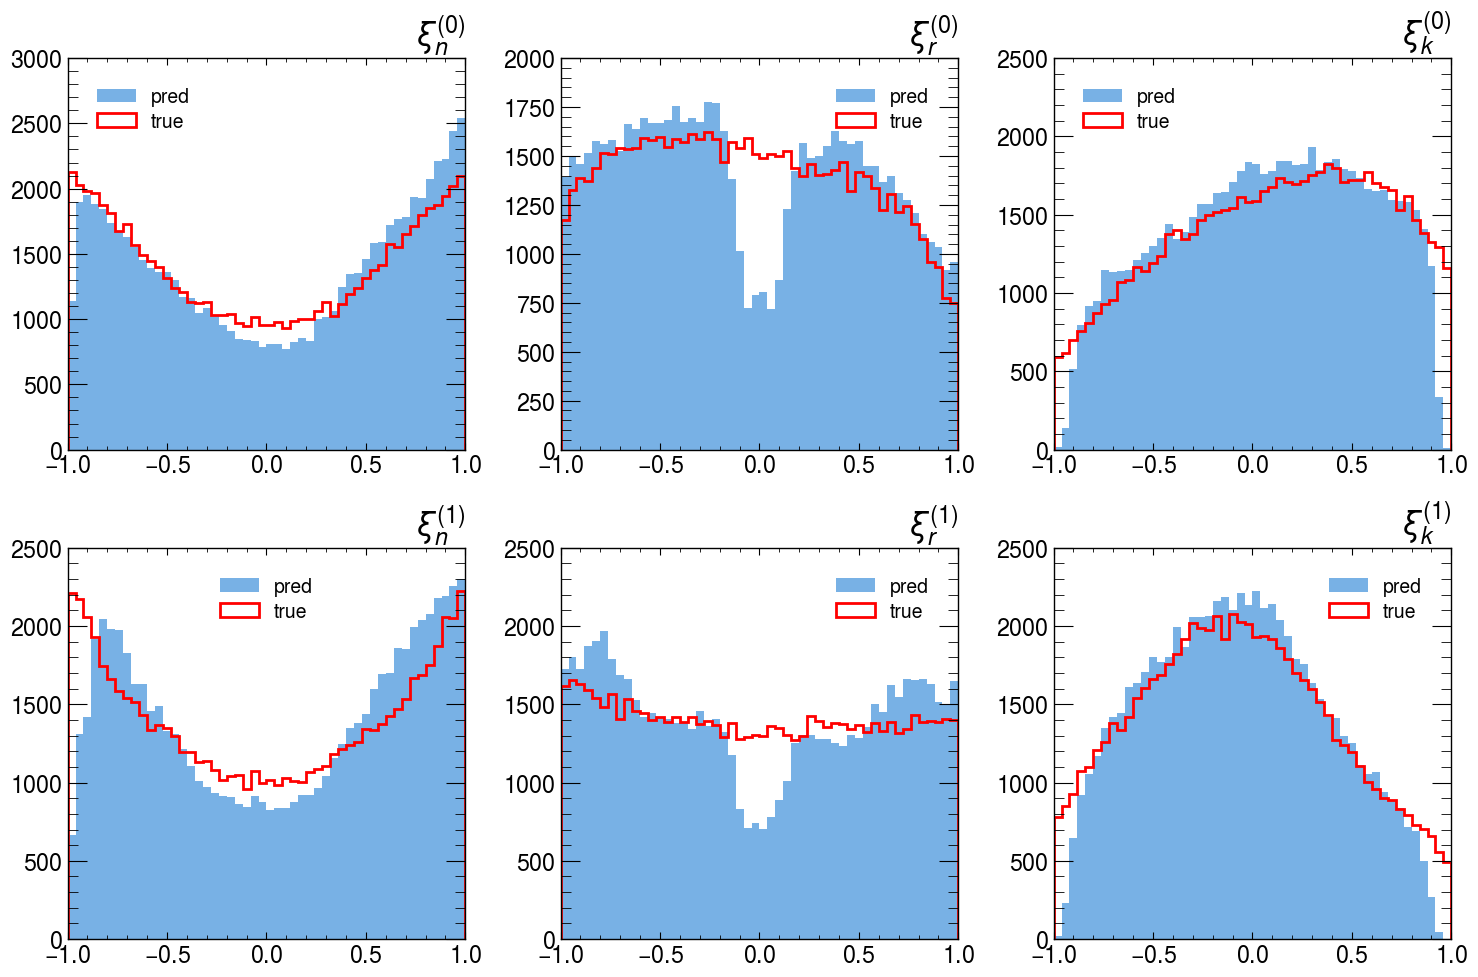

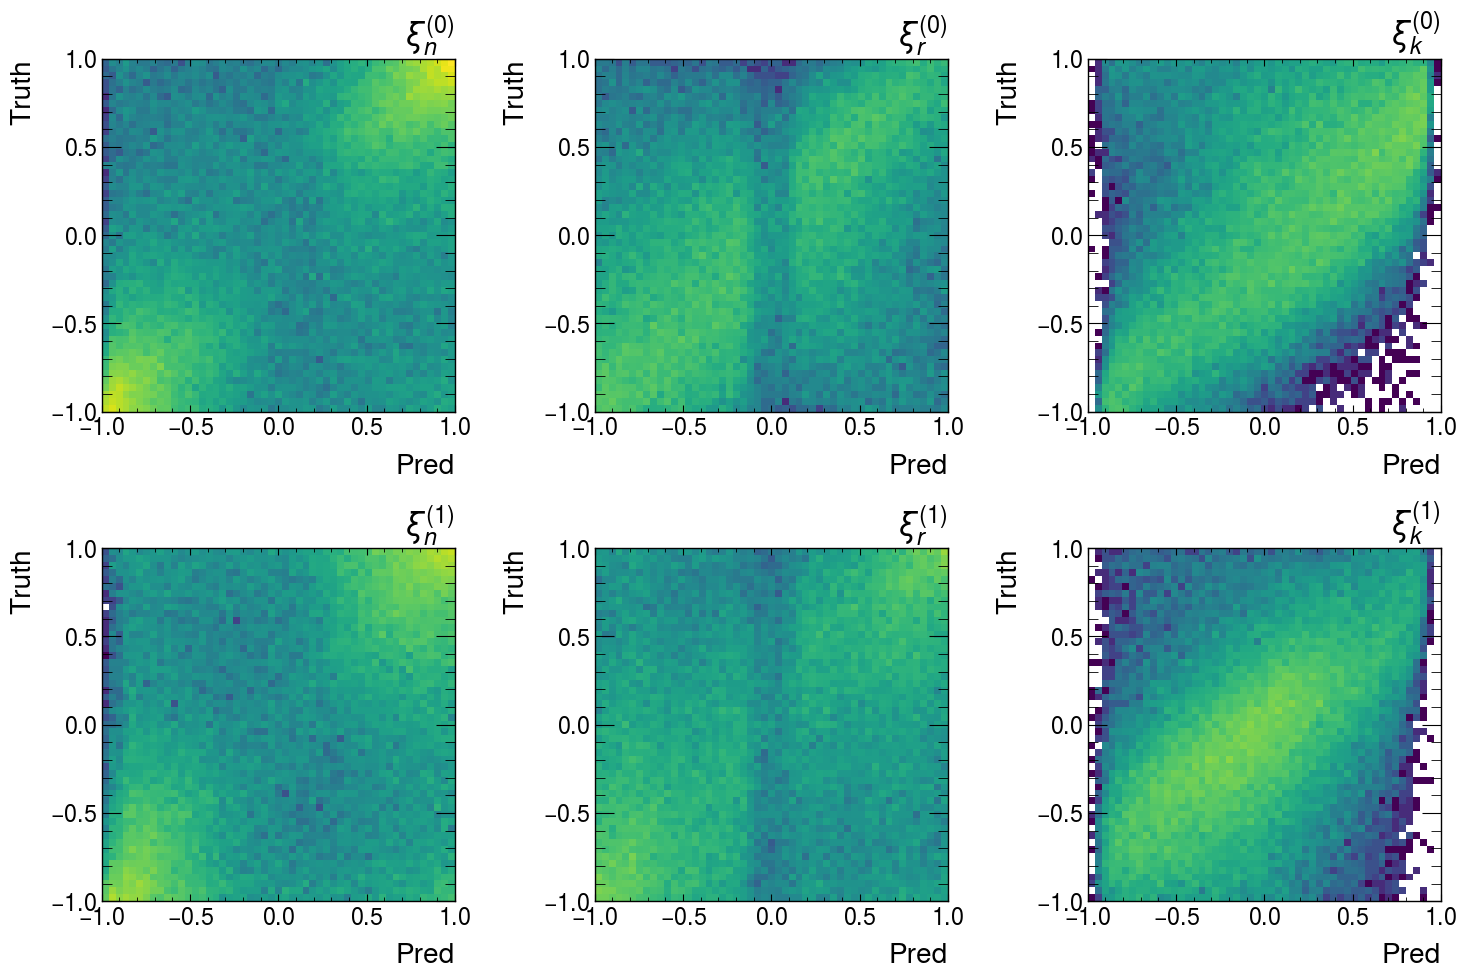

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [19]:
def xi_n(theta, phi):
    return np.sin(theta * np.pi) * np.cos(phi * np.pi)
def xi_r(theta, phi):
    return np.sin(theta * np.pi) * np.sin(phi * np.pi)
def xi_k(theta, phi):
    return np.cos(theta * np.pi)

# Calculate xi components for both predicted and truth values
lead_xi = {
    'n': xi_n(pred_lead_w_theta, pred_lead_w_phi),
    'r': xi_r(pred_lead_w_theta, pred_lead_w_phi),
    'k': xi_k(pred_lead_w_theta, pred_lead_w_phi)
}
sublead_xi = {
    'n': xi_n(pred_sublead_w_theta, pred_sublead_w_phi),
    'r': xi_r(pred_sublead_w_theta, pred_sublead_w_phi),
    'k': xi_k(pred_sublead_w_theta, pred_sublead_w_phi)
}
truth_lead_xi = {
    'n': xi_n(label_lead_w_theta, label_lead_w_phi),
    'r': xi_r(label_lead_w_theta, label_lead_w_phi),
    'k': xi_k(label_lead_w_theta, label_lead_w_phi)
}
truth_sublead_xi = {
    'n': xi_n(label_sublead_w_theta, label_sublead_w_phi),
    'r': xi_r(label_sublead_w_theta, label_sublead_w_phi),
    'k': xi_k(label_sublead_w_theta, label_sublead_w_phi)
}

bins_edges = np.linspace(-1, 1, 51)

# 1D histogram plots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
components = ['n', 'r', 'k']

for i, component in enumerate(components):
    # Lead lepton (top row)
    axes[0, i].hist(lead_xi[component], bins=bins_edges, 
                    label=f"pred", alpha=0.7)
    axes[0, i].hist(truth_lead_xi[component], bins=bins_edges, 
                    label=f"true", 
                    histtype="step", linewidth=2, color="red")
    axes[0, i].legend()
    axes[0, i].set_title(f"$\\xi_{component}^{{(0)}}$", loc="right")
    
    # Sublead lepton (bottom row)
    axes[1, i].hist(sublead_xi[component], bins=bins_edges, 
                    label=f"pred", alpha=0.7)
    axes[1, i].hist(truth_sublead_xi[component], bins=bins_edges, 
                    label=f"true", 
                    histtype="step", linewidth=2, color="red")
    axes[1, i].legend()
    axes[1, i].set_title(f"$\\xi_{component}^{{(1)}}$", loc="right")

plt.tight_layout()
plt.show()

# 2D histogram plots (2 rows, 3 columns) with shared colorbar
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Create all 2D histograms and store them to find global min/max for colorbar
hist_data = []
for i, component in enumerate(components):
	# Lead lepton
	h1, _, _ = np.histogram2d(lead_xi[component], truth_lead_xi[component], 
								bins=(51, 51), range=([-1, 1], [-1, 1]))
	hist_data.append(h1)

	# Sublead lepton
	h2, _, _ = np.histogram2d(sublead_xi[component], truth_sublead_xi[component], 
								bins=(51, 51), range=([-1, 1], [-1, 1]))
	hist_data.append(h2)

	# Find global min/max for consistent colorbar
	vmin = max(1, min([h[h > 0].min() for h in hist_data if np.any(h > 0)]))
	vmax = max([h.max() for h in hist_data])

	for i, component in enumerate(components):
		# Lead lepton (top row)
		im1 = axes[0, i].hist2d(lead_xi[component], truth_lead_xi[component], 
							bins=(51, 51), range=([-1, 1], [-1, 1]),
							cmap="viridis", cmin=vmin, norm=LogNorm(vmin=vmin, vmax=vmax))
		axes[0, i].set_aspect("equal", adjustable="box")
		axes[0, i].set_ylabel("Truth")
		axes[0, i].set_xlabel("Pred")
		axes[0, i].set_title(f"$\\xi_{component}^{{(0)}}$", loc="right")
		
		# Sublead lepton (bottom row)
		im2 = axes[1, i].hist2d(sublead_xi[component], truth_sublead_xi[component], 
							bins=(51, 51), range=([-1, 1], [-1, 1]),
							cmap="viridis", cmin=vmin, norm=LogNorm(vmin=vmin, vmax=vmax))
		axes[1, i].set_aspect("equal", adjustable="box")
		axes[1, i].set_ylabel("Truth")
		axes[1, i].set_xlabel("Pred")
		axes[1, i].set_title(f"$\\xi_{component}^{{(1)}}$", loc="right")

	# # Add shared colorbar
	# fig.subplots_adjust(right=0.8)
	# cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
	# fig.colorbar(im1[3], cax=cbar_ax, label="Counts")

	plt.tight_layout()
	plt.show()